# DEMO: Running FastCAM using SMOE Scale Saliency Maps

## Initial code setup

In [1]:
import os
import torch
from torchvision import models
from IPython.display import Image

Lets load things we need for **Grad-CAM**

In [2]:
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F

#from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM

# The GradCAM kit throws a warning we don't need to see for this demo. 
import warnings
warnings.filterwarnings('ignore')

Now we import the code for **this package**.

In [3]:
import maps
import misc
import mask
import resnet

This is where we can set some parameters like the image name and the layer weights.

In [4]:
input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # Our input image to process 
output_dir          = 'outputs'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from
weights             = [0.18, 0.15, 0.37, 0.4, 0.72]             # Our saliency layer weights 
                                                                # From paper:
                                                                # https://arxiv.org/abs/1911.11293
in_height           = 224                                       # Size to scale input image to
in_width            = 224                                       # Size to scale input image to

Lets set up where to save output and what name to use. 

In [5]:
save_prefix         = os.path.split(os.path.splitext(input_image_name)[0])[-1]  # Chop the file extension and path
load_image_name     = os.path.join(input_dir, input_image_name)

os.makedirs(output_dir, exist_ok=True)

Good Doggy!

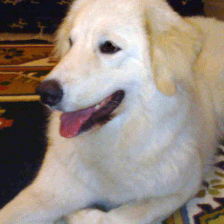

In [6]:
Image(filename=load_image_name) 

Now we create a model in PyTorch and send it to our device.

In [7]:
device              = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model               = models.resnet50(pretrained=True)
model               = model.to(device)

You will need to pick out which layers to process. Here we grab the end of each group of layers by scale.

In [8]:
layers              = ['relu','layer1','layer2','layer3','layer4']

Lets load in our image. We will do a simple resize on it.

In [9]:
in_tensor   = misc.LoadImageToTensor(load_image_name, device)
in_tensor   = F.interpolate(in_tensor, size=(in_height, in_width), mode='bilinear', align_corners=False)

Create our saliency map object. We hand it our Torch model and names for the layers we want to tap. 

In [10]:
get_salmap  = maps.SaliencyMap(model, layers, output_size=[in_height,in_width],
                               weights=weights)

Lets got ahead and run the network and get back the saliency map 

In [11]:
csmap,smaps,_ = get_salmap(in_tensor)

## Run With Grad-CAM or Grad-CAM++

Let's go ahead and push our network model into the Grad-CAM library.

**NOTE** much of this code is borrowed from the Pytorch GradCAM package. 

In [12]:
resnet_gradcampp4   = GradCAMpp.from_config(model_type='resnet', arch=model, layer_name='layer4')

Let's get our original input image back. We will just use this one for visualization. 

In [13]:
raw_tensor  = misc.LoadImageToTensor(load_image_name, device, norm=False)
raw_tensor  = F.interpolate(raw_tensor, size=(in_height, in_width), mode='bilinear', align_corners=False)

We create an object to get back the mask of the saliency map

In [14]:
getMask     = mask.SaliencyMaskDropout(keep_percent = 0.1, scale_map=False)

Now we will create illustrations of the combined saliency map. 

In [15]:
images      = []
images      = misc.TileOutput(raw_tensor,csmap,images,getMask)

Now, lets get the Grad-CAM++ saliency map only.

In [16]:
cam_map, logit = resnet_gradcampp4(in_tensor)

Let's double check and make sure it's picking the correct class

In [17]:
too_logit = logit.max(1)
print("Network Class Output: {} : Value {} ".format(too_logit[1][0],too_logit[0][0]))

Network Class Output: 222 : Value 16.058656692504883 


Now visualize the results

In [18]:
images      = misc.TileOutput(raw_tensor,cam_map.squeeze(0),images,getMask)

### Combined CAM and SMOE Scale Maps
Now we combine the Grad-CAM map and the SMOE Scale saliency maps in the same way we would combine Grad-CAM with Guided Backprop.

In [19]:
fastcam_map = csmap*cam_map

Now let's visualize the combined saliency map from SMOE Scale and GradCAM++.

In [20]:
images      = misc.TileOutput(raw_tensor,fastcam_map.squeeze(0),images,getMask)

### Get Non-class map
Now we combine the Grad-CAM map and the SMOE Scale saliency maps but create a map of the **non-class** objects. These are salient locations that the network found interesting, but are not part of the object class. 

In [21]:
nonclass_map = csmap*(1.0 - cam_map)

Now let's visualize the combined non-class saliency map from SMOE Scale and GradCAM++.

In [22]:
images      = misc.TileOutput(raw_tensor,nonclass_map.squeeze(0),images,getMask)

### Visualize this....
We now put all the images into a nice grid for display.

In [23]:
images      = make_grid(torch.cat(images,0), nrow=5)

... save and look at it. 

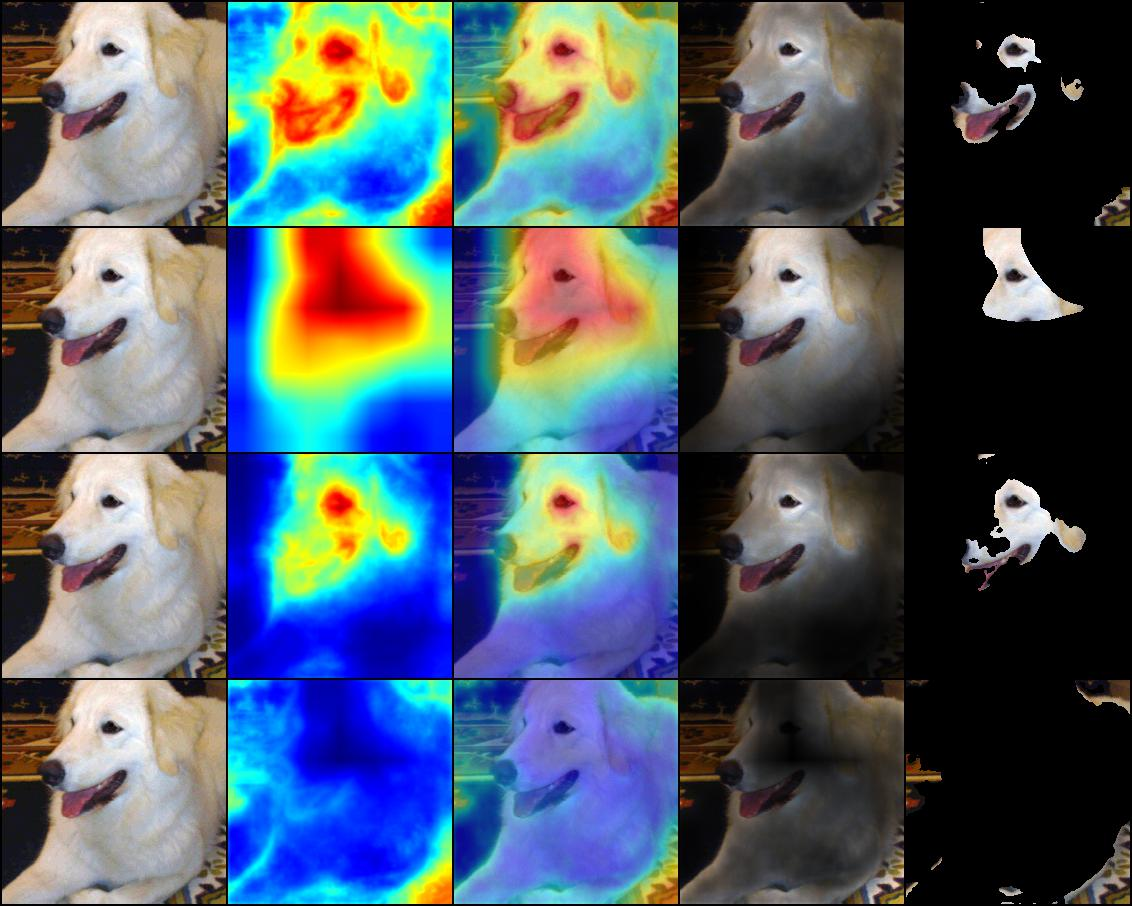

In [24]:
output_name = "{}.CAM_PP.jpg".format(save_prefix)
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image(filename=output_path) 

The top row is the SMOE Scale based saliency map. The second row is GradCAM++ only. Next we have the FastCAM output from combining the two. The last row is the non-class map showing salient regions that are not associated with the output class.

This image should look **exactly** like the one on the README.md on Github minus the text. 